# Prepare Environment

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from IPython.display import display

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
%matplotlib inline

In [2]:
import numpy as np
import keras
import tensorflow as tf

# Load MNIST dataset

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits.

Ref: http://yann.lecun.com/exdb/mnist/

In [3]:
from keras.datasets import mnist

# Download MNIST dataset using `datasets` module in Keras
# Note: the data have already been split into training and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(f'Training set: {x_train.shape}, {y_train.shape}')
print(f'Test set: {x_test.shape}, {y_test.shape}')

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set: (60000, 28, 28), (60000,)
Test set: (10000, 28, 28), (10000,)


Let's look at some examples of the training and test sets.

Training set


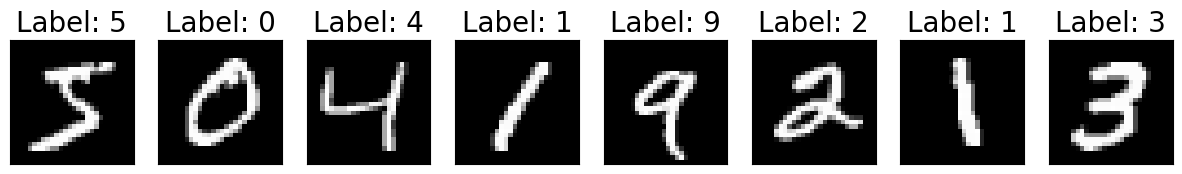

Test set


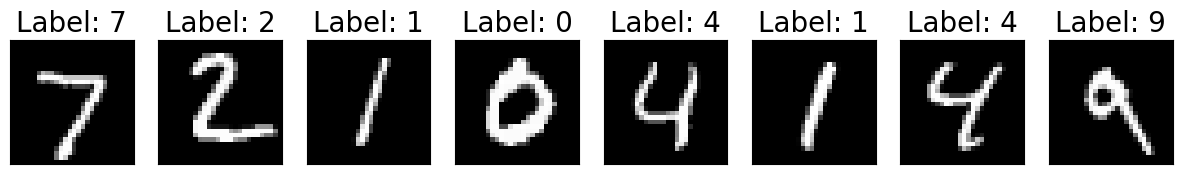

In [4]:
def plot_mnist_data(data, label, n_images):
    img_w = 28
    img_h = 28
    image = np.reshape(data, (-1, img_h, img_w))

    f, axs = plt.subplots(1, n_images)
    f.set_figheight(15)
    f.set_figwidth(15)
    for i in range(len(axs)):
        axs[i].imshow(image[i], cmap="gray")
        axs[i].set_title(f"Label: {label[i]}", fontsize=20)
        axs[i].tick_params(
            axis='both',
            which='both',
            bottom=False, top=False,left=False, right=False,
            labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.show()
    plt.close("all")

print("Training set")
plot_mnist_data(x_train, y_train, n_images=8)

print("Test set")
plot_mnist_data(x_test, y_test, n_images=8)

# Data Preprocessing
As our model is going to take a single vector for each training example, we need to reshape the inputs (i.e., `x`) so that each 28x28 image becomes a single 784-dimensional vector.

In [5]:
# MNIST parameters
num_classes = 10
img_h, img_w = 28, 28

# Reshape the input so that each 28x28 image becomes a single 784-dimensional vector
x_train = x_train.reshape(x_train.shape[0], img_h * img_w)
x_test = x_test.reshape(x_test.shape[0], img_h * img_w)

# Convert from int to float format
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

## Feature Scaling

It is a common pratice to **normalize the range of independent variables or features of data**. This is mainly because many classifiers calculate the distance between two points by the Euclidean distance. If one of the features has a broad range of values, the distance will be governed by this particular feature. Therefore, the range of all features should be normalized **so that each feature contributes approximately proportionately to the final distance**.

There are many other feature scaling techniques, which can be found in [here](https://en.wikipedia.org/wiki/Feature_scaling).

In this MNIST example, we'll only scale the inputs to be in the range [0-1] rather than [0-255].

In [6]:
# Scale the MNIST data to be in the range [0-1]
# Note: The maximum value of color value is 255
x_train /= 255
x_test /= 255

## Convert from class data into one-hot format

We also have to modify the labels to be in the one-hot format, i.e.
```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

In [7]:
# Convert class data to one-hot format
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

Here are the shapes of the training and test sets after preprocessing.

In [8]:
print(f"Training set: {x_train.shape} {y_train.shape}")
print(f"Test set: {x_test.shape} {y_test.shape}")

Training set: (60000, 784) (60000, 10)
Test set: (10000, 784) (10000, 10)


# Define a Model

We are going to define a neural network, or what is typically referred to as a deep learning model. Here, we will do a simple 3-layer fully-connected network.

<!--<img src="./img/fc_mnist.png" alt="Fully-connected Network" style="width:500px;"/>-->
<img src="https://www.dropbox.com/s/6a05qtkgmlih6s4/fc_mnist.png?raw=1" alt="Fully-connected Network" style="width:500px;"/>

In [9]:
from keras.models import Sequential
from keras.layers import *

# Feed-forward neural network
model = Sequential()

# Layer 1 - Hidden
# Number of neurons (or units) is 128.
# Activation function is rectified linear unit (ReLU).
model.add(Dense(128, activation='relu'))

# Layer 2 - Hidden
# Number of neurons (or units) is 128.
# Activation function is rectified linear unit (ReLU).
model.add(Dense(128, activation='relu'))

# Layer 3 - Output
# Number of neurons is 10 (i.e., number of output classes).
# Activation function is softmax.
# Note: the softmax function is commonly used in
#       the classification problem to normalize a
#       K-dimensional output vector into a probability
#       distribution of classes.
num_classes = 10
model.add(Dense(num_classes, activation='softmax'))

# Train a Model

In this section, we will first define several parameters that will be used during the training.

*   `epochs`: the number of training epochs (one epoch means the model has seen the entire training samples one times).
*   `batch_size`: the number of examples per one training step.
*   `learning_rate`: a hyperparameter that defines the adjustment in the weights of our network with respect to the loss gradient.


In [10]:
epochs = 20
batch_size = 256
learning_rate = 0.01

## Loss Function

Before we train a model, we need to specify the **loss function**, `loss`, that will be used to quantify the error between the predicted and the target classes. As we would like to train our model to differentiate among 10 handwritten digits in MNIST dataset, a loss function that we can use is *cross-entropy*. Cross-entropy is a measure of how different your predicted distribution is from the target distribution (see [Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy) for more details).

In this exercise, we will use the cross-entropy.

Keras also provides many other loss functions for other problems as well. You can read more [here](https://keras.io/losses/).

In [11]:
# Cross-entropy loss
loss = keras.losses.categorical_crossentropy

## Optimizer

Another component that we need to specify before the training is the **optimizer**, `optimizer`. The optimizers that are commonly used to train deep learning models are Stochastic Gradient Descent (SGD), Adam, RMSProp, Adadelta, etc. The list of optimizers provided by Keras can be found [here](https://keras.io/optimizers/).

Here we will use SGD.

In [12]:
# Stochastic gradient descent (SGD)
optimizer = tf.keras.optimizers.SGD(learning_rate)

## Compile Keras Model

Next, we configures the model for training by calling.

In [13]:
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy'])

## Train a model

We are now ready to train our model. Let's start feeding the data to train the model and it will learn to classify digits.

In [14]:
hist = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1)

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2782 - loss: 2.1393
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7634 - loss: 1.1343
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8473 - loss: 0.6442
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8695 - loss: 0.4980
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8819 - loss: 0.4334
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8929 - loss: 0.3934
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8980 - loss: 0.3677
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9025 - loss: 0.3499
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9084 - loss: 0.3294
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9112 - loss: 0.3138
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9118 - loss: 0.3105
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

# Apply the Trained Model on MNIST images

Once we have finished the model training, we can now apply it to MNIST images.

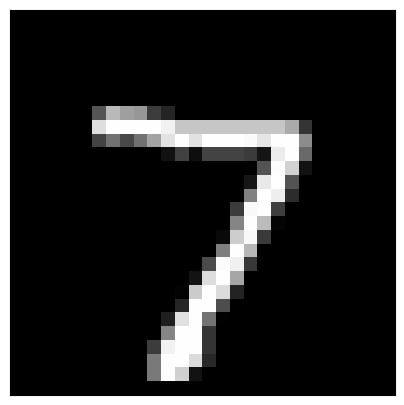

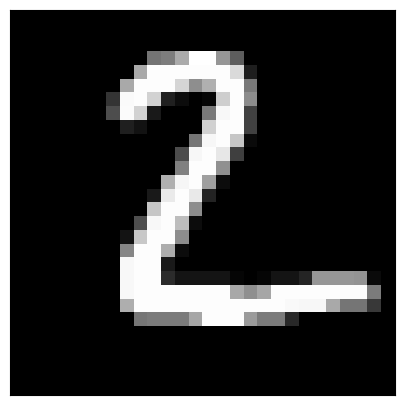

In [15]:
# Sample two MNIST images from the training set
test_imgs = x_test[0:2]

# Plot images
for idx in range(len(test_imgs)):
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(5)
    ax.imshow(test_imgs[idx].reshape((img_h, img_w)), cmap="gray")
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False, top=False,left=False, right=False,
        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

In [16]:
# Predict the labels of these images
probs = model.predict(test_imgs)

# Convert the label back to the original format
prob_classes = np.argmax(probs, axis=-1)

# Print the probability distribution
for idx in range(len(probs)):
    for i in range(num_classes):
        print(f'{i}: {probs[idx][i]:.4f}')
    print(f'Predicted class: {prob_classes[idx]}')
    print('')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
0: 0.0002
1: 0.0000
2: 0.0005
3: 0.0042
4: 0.0000
5: 0.0001
6: 0.0000
7: 0.9944
8: 0.0001
9: 0.0006
Predicted class: 7

0: 0.0063
1: 0.0006
2: 0.9476
3: 0.0125
4: 0.0000
5: 0.0043
6: 0.0246
7: 0.0000
8: 0.0041
9: 0.0000
Predicted class: 2



# Evaluate Performance on Test Set

Once you have finished the model training, you then evaluate the classification performance on the test set (i.e., the unseen dataset).

In [17]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.23876428604125977
Test accuracy: 0.9326000213623047


# Analyze the Predictions

It's always a good idea to inspect the output and make sure everything looks fine. Here we'll look at some examples our model gets right, and some examples it gets wrong on the test sets.

First, we use the trained model to predict the labels of the test sets.

In [18]:
# We use the trained model to predict the labels of the test set
prob_classes = model.predict(x_test)

# The output class is the one with the highest probability
pred_classes = np.argmax(prob_classes, axis=-1)

# Convert the label back to the original format
y_test_classes = np.argmax(y_test, axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Next we determine which samples are correct or incorrect.

In [19]:
correct_indices = np.where(pred_classes == y_test_classes)[0]
incorrect_indices = np.where(pred_classes != y_test_classes)[0]

Then we plot the images with their corresponding classes. In the incorrect case, we also plot the ground truth classes for comparison.

Correct cases


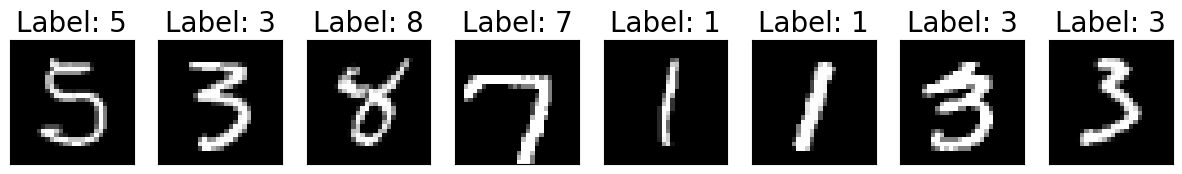

Incorrect cases


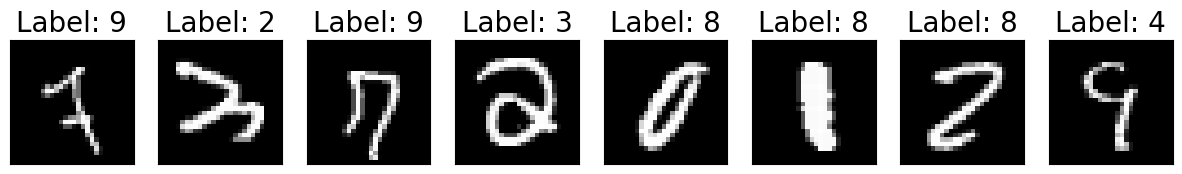

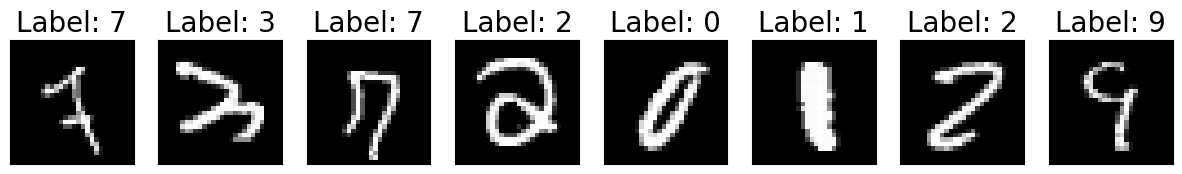

In [20]:
print("Correct cases")
correct_x_test = x_test[correct_indices]
correct_preds = pred_classes[correct_indices]
idx = np.random.choice(np.arange(len(correct_x_test)), 8)
plot_mnist_data(correct_x_test[idx], correct_preds[idx], 8)

print("Incorrect cases")
incorrect_x_test = x_test[incorrect_indices]
incorrect_preds = pred_classes[incorrect_indices]
correct_labels = y_test_classes[incorrect_indices]
idx = np.random.choice(np.arange(len(incorrect_x_test)), 8)
plot_mnist_data(incorrect_x_test[idx], incorrect_preds[idx], 8)
plot_mnist_data(incorrect_x_test[idx], correct_labels[idx], 8)

# Play around

Now it is your turn! Let's try to change the model architecture and the optimizer to see the effects.

For example,
* Change the number of fully-connected layers (in this [section](#define-model))
    * e.g., 2, 3, 4 layers
* Change the number of hidden units (in this [section](#define-model))
    * e.g., 10, 128, 256, 512
* Change the optimizers (i.e., `optimizer`)
    * e.g., [keras.optimizers.RMSprop](https://keras.io/optimizers/#rmsprop), [keras.optimizers.Adadelta](https://keras.io/optimizers/#adadelta), [keras.optimizers.Adam](https://keras.io/optimizers/#adam)
* Change the learning rate of the optimizer (i.e., `learning_rate`)
    * e.g., 10000, 0.00001, 0.001
* Change the number of training epochs (i.e., `epochs`)
    * e.g., 1, 10, 20